ctrl shift f10 - search commands

# Imports

In [1]:
import numpy as np
import PIL
import tensorflow as tf
import pathlib

In [2]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('TPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pickle

In [6]:
# Importing necessary libraries
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


In [7]:
import os
import cv2
from google.colab.patches import cv2_imshow

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [8]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [9]:
!unzip '/content/gdrive/MyDrive/Plants Project/Plants_T_GHL'

Streaming output truncated to the last 5000 lines.
  inflating: Plants_T_GHL/Train/Apple/Apple scab/66__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/67__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/68__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/69__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/7__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/70__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/71__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/72__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/73__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/74__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/75__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/76__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/

# temp - count

In [10]:
xpath = '/content/Plants_T_GHL/'
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

5880


# Some functions

In [11]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

# Test

## Corn

In [12]:
diseases = ['Common rust', 'Gray leaf spot', 'Healthy']
imgtypes = [ "Corn" ]
for disease in diseases:
  for imgtype in imgtypes:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Corn/Common rust/402__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/400__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/388__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/403__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/404__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/401__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/407__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/411__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/395__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/392__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/414__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/387__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Common rust/386__Corn__Common rust.JPG', '/content/Plants_T_GHL/Test/Corn/Comm

In [13]:
xpath = '/content/Plants_T_GHL/Train/Corn/'
data_dir = pathlib.Path(xpath)
class_names_corn = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_corn = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names_corn, input_shape = (180, 180, 3)
)
x = layers.Flatten()(base_model_corn.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_corn), activation = 'softmax')(x)

head_model_corn = Model(inputs = base_model_corn.input, outputs = predictions)
head_model_corn.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_corn.load_weights('/content/gdrive/MyDrive/Corn/checkpoints/Corn_1')

115277824/115263384 [==============================] - 1s 0us/step


In [14]:
def test_corn(tpath):
  img = tf.keras.utils.load_img(
    tpath, target_size=(180, 180)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_corn.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_corn[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_corn[np.argmax(score)], 100 * np.max(score)

## Apple

In [15]:
diseases = ['Apple scab', 'Black rot', 'Healthy']
imgtypes = [ "Apple" ]
for disease in diseases:
  for imgtype in imgtypes:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Apple/Apple scab/412__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/391__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/385__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/389__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/384__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/395__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/400__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/390__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/415__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/406__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/399__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/420__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/388__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/App

In [16]:
xpath = '/content/Plants_T_GHL/Train/Apple/'
data_dir = pathlib.Path(xpath)
class_names_apple = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_apple = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names_apple, input_shape = (180, 180, 3)
)
x = layers.Flatten()(base_model_apple.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_apple), activation = 'softmax')(x)

head_model_apple = Model(inputs = base_model_apple.input, outputs = predictions)
head_model_apple.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_apple.load_weights('/content/gdrive/MyDrive/Apple/checkpoints/Apple_1')

In [17]:
def test_apple(tpath):
  img = tf.keras.utils.load_img(
      tpath, target_size=(180, 180)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_apple.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_apple[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_apple[np.argmax(score)], 100 * np.max(score)

## Tomato

In [18]:
diseases = ['Early blight', 'Leaf mold', 'Septoria leaf spot']
imgtypes = [ "Tomato" ]
for disease in diseases:
  for imgtype in imgtypes:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "//"+disease)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Tomato//Early blight/398__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/416__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/391__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/413__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/400__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/387__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/414__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/412__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/419__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/384__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/405__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test/Tomato//Early blight/392__Tomato__Early blight.JPG', '/content/Plants_T_GHL/Test

In [19]:
xpath = '/content/Plants_T_GHL/Train/Tomato/'
data_dir = pathlib.Path(xpath)
class_names_tomato = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_tomato = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names_tomato, input_shape = (180, 180, 3)
)
x = layers.Flatten()(base_model_tomato.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_tomato), activation = 'softmax')(x)

head_model_tomato = Model(inputs = base_model_tomato.input, outputs = predictions)
head_model_tomato.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_tomato.load_weights('/content/gdrive/MyDrive/Plants Project/my_checkpoint/Tomato/eff_23')


In [20]:
def test_tomato(tpath):
  img = tf.keras.utils.load_img(
      tpath, target_size=(180, 180)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_tomato.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_tomato[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_tomato[np.argmax(score)], 100 * np.max(score)

## Grape

In [21]:
diseases = ['Esca', 'Isariopsis', 'Black rot']
imgtypes = [ "Grapes" ]
severity = ['Low', 'High']
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "//"+disease+"//"+ sev)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Grapes//Esca//Low/203__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/210__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/194__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/200__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/209__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/199__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/204__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/195__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/206__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/202__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/191__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/208__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes//Esca//Low/201__Segmented__E

In [22]:
imgtypes = [ "Grapes" ]
for imgtype in imgtypes:
  srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+"//Healthy"+"//No label")
  print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Grapes//Healthy//No label/398__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/415__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/406__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/410__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/420__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/399__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/409__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/396__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/408__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/397__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/392__Segmented__Healthy.JPG', '/content/Plants_T_GHL/Test/Grapes//Healthy//No label/419__Segmented__Healt

In [23]:
xpath = '/content/Plants_T_GHL/Train/Grapes/'
data_dir = pathlib.Path(xpath)
class_names_grape = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_grape = tf.keras.applications.densenet.DenseNet201(
    include_top=False, weights='imagenet', classes=class_names_grape, input_shape = (229, 229, 3)
)
x = layers.Flatten()(base_model_grape.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_grape), activation = 'softmax')(x)

head_model_grape = Model(inputs = base_model_grape.input, outputs = predictions)
head_model_grape.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_grape.load_weights('/content/gdrive/MyDrive/Grapes/my_checkpoint20_1_densenet_Segmented' )

74850304/74836368 [==============================] - 3s 0us/step


In [24]:
def test_grapes(tpath):
  img = tf.keras.utils.load_img(
    tpath, target_size=(229, 229)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_grape.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_grape[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_grape[np.argmax(score)], 100 * np.max(score)
  

### Esca

In [25]:
diseases = ['Esca']
imgtypes = [ "Grapes" ]
severity = ['Low', 'High']
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease+"/"+ sev)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Grapes/Esca/Low/203__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/210__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/194__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/200__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/209__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/199__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/204__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/195__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/206__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/202__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/191__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/208__Segmented__Esca__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Esca/Low/201__Segmented__Esca__Low.JPG', '/content/P

In [26]:
xpath = '/content/Plants_T_GHL/Train/Grapes/Esca'
data_dir = pathlib.Path(xpath)
class_names_esca = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_esca = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', classes=class_names_esca, input_shape = (229, 229, 3)
)
x = layers.Flatten()(base_model_esca.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_esca), activation = 'softmax')(x)

head_model_esca = Model(inputs = base_model_esca.input, outputs = predictions)
head_model_esca.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_esca.load_weights('/content/gdrive/MyDrive/Esca/checkpoints/HighLow/my_checkpoint_HL_Esca_1_Segmented_2')

27033600/27018416 [==============================] - 0s 0us/step


In [27]:
def test_esca(tpath):
  img = tf.keras.utils.load_img(
    tpath, target_size=(229, 229)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_esca.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_esca[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_esca[np.argmax(score)], 100 * np.max(score)

### black rot

In [28]:
diseases = ['Black rot']
imgtypes = [ "Grapes" ]
severity = ['Low', 'High']
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease+"/"+ sev)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Grapes/Black rot/Low/200__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/207__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/191__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/198__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/197__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/196__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/209__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/205__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/195__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/201__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/192__Segmented__Black rot__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Black rot/Low/199_

In [29]:
xpath = '/content/Plants_T_GHL/Train/Grapes/Black rot'
data_dir = pathlib.Path(xpath)
class_names_blackrot = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_blackrot = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', classes=class_names_blackrot, input_shape = (229, 229, 3)
)
x = layers.Flatten()(base_model_blackrot.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_blackrot), activation = 'softmax')(x)

head_model_blackrot = Model(inputs = base_model_blackrot.input, outputs = predictions)
head_model_blackrot.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_blackrot.load_weights('/content/gdrive/MyDrive/Black rot/my_checkpoint_HL_Black rot_1_Segmented')

In [30]:
def test_blackrot(tpath):
  img = tf.keras.utils.load_img(
    tpath, target_size=(229, 229)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_blackrot.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_blackrot[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_blackrot[np.argmax(score)], 100 * np.max(score)

## Isariopsis

In [31]:
diseases = ['Isariopsis']
imgtypes = [ "Grapes" ]
severity = ['Low', 'High']
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease+"/"+ sev)
      print(getfiles(srcpath))

['/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/198__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/201__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/191__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/197__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/193__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/199__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/207__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/195__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/209__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/200__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/208__Segmented__Isariopsis__Low.JPG', '/content/Plants_T_GHL/Test/Gra

In [32]:
class_names_Isariopsis = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
base_model_Isariopsis = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', classes=class_names_Isariopsis, input_shape = (229, 229, 3)
)
x = layers.Flatten()(base_model_Isariopsis.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names_Isariopsis), activation = 'softmax')(x)

head_model_Isariopsis = Model(inputs = base_model_Isariopsis.input, outputs = predictions)
head_model_Isariopsis.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model_Isariopsis.load_weights('/content/gdrive/MyDrive/Plants Project/my_checkpoint/Isariopsis/eff_HL_1')

In [33]:
def test_Isariopsis(tpath):
  img = tf.keras.utils.load_img(
    tpath, target_size=(229, 229)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model_Isariopsis.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_Isariopsis[np.argmax(score)], 100 * np.max(score))
  )
  return class_names_Isariopsis[np.argmax(score)], 100 * np.max(score)

## SVM

In [34]:
class_names = ['Apple', 'Corn', 'Grapes', 'Tomato']
l_model = None
with open("/content/gdrive/MyDrive/Plants Project/edge_svm_model_" + str(10) + "x" + str(10) +"_88p.pkl", "rb") as file:
  global l_model
  l_model = pickle.Unpickler(file)
  l_model = l_model.load()

In [35]:
def test_svm(img):
  print('------------Start: SVM---------------')

  global l_model
  # img=imread(url)
  plt.imshow(img)
  plt.show()
  img_resize=resize(img,(10, 10,1))
  l=[img_resize.flatten()]
  probability=l_model.predict_proba(l)
  for ind,val in enumerate(class_names):
      print(f'{val} = {probability[0][ind]*100}%')
  print("The predicted image is : "+class_names[l_model.predict(l)[0]])
  print('------------End: SVM---------------')

  return class_names[l_model.predict(l)[0]]

## Edge detect

In [36]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, 229, 229)
  return img

In [37]:
def edge_detection(tpath):

  print('------------Start: Edge detection---------------')
  img = cv2.imread(tpath)
  cv2_imshow(img)
  cv2.waitKey(0)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
  edges = cv2.Canny(image=img_blur, threshold1=75, threshold2=200) # Canny Edge Detection
  cv2_imshow(edges)
  print('------------End: Edge detection---------------')

  return edges

# Predict

In [38]:
print(getfiles('/content/Plants_T_GHL/Test/'))

['/content/Plants_T_GHL/Test/419__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/387__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/383__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/409__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/413__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/410__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/390__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/384__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/414__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/397__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/417__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/399__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/415__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/408__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/388__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/391__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/403__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test/398__Apple__Healthy.JPG', '/content/Plants_T_GHL/Test

In [39]:
def predict_disease(tpath):
  print('Given path: ', tpath) 

  svm_op = test_svm(edge_detection(tpath))
  if svm_op == "Apple":
    print('------------Start: CNN - Apple---------------')
    print(test_apple(tpath))
    print('------------End: CNN - Apple---------------')
  if svm_op == "Tomato":
    print('------------Start: CNN - Tomato---------------')
    print(test_tomato(tpath))
    print('------------End: CNN - Tomato---------------')
  if svm_op == "Corn":
    print('------------Start: CNN - Corn---------------')
    print(test_corn(tpath))
    print('------------End: CNN - Corn---------------')
  if svm_op == "Grapes":
    print('------------Start: CNN - Grapes---------------')
    grape_op = test_grapes(tpath)
    print(grape_op)
    if grape_op[0] == 'Esca':
      print('------------Start: CNN - Grapes - Esca---------------')
      print(test_esca(tpath))
      print('------------End: CNN - Grapes - Esca---------------')
    if grape_op[0] == 'Black rot':
      print('------------Start: CNN - Grapes - blackrot---------------')
      print(test_blackrot(tpath))
      print('------------End: CNN - Grapes - blackrot---------------')
    if grape_op[0] == 'Isariopsis':
      print('------------Start: CNN - Grapes - Isariopsis---------------')
      print(test_Isariopsis(tpath))
      print('------------End: CNN - Grapes - Isariopsis---------------')
    print('------------End: CNN - Grapes---------------')

Enter the image url: /content/Plants_T_GHL/Test/Apple/Apple scab/381__Apple__Apple scab.JPG
Given path:  /content/Plants_T_GHL/Test/Apple/Apple scab/381__Apple__Apple scab.JPG
------------Start: Edge detection---------------


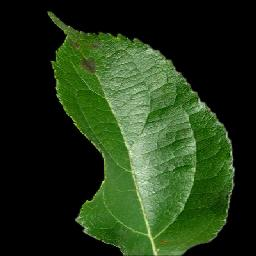

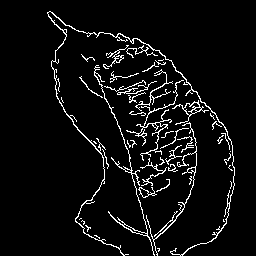

------------End: Edge detection---------------
------------Start: SVM---------------


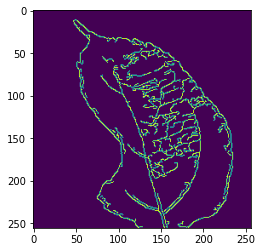

Apple = 97.42584944448333%
Corn = 0.2077405551533819%
Grapes = 0.1277546225046253%
Tomato = 2.2386553778586658%
The predicted image is : Apple
------------End: SVM---------------
------------Start: CNN - Apple---------------
This image most likely belongs to Apple scab with a 57.59 percent confidence.
('Apple scab', 57.59081840515137)
------------End: CNN - Apple---------------


In [59]:
tpath = input("Enter the image url: ")
# tpath = '/content/Plants_T_GHL/Test/Apple/Black rot/413__Apple__Black rot.JPG'
predict_disease(tpath)

Given path:  /content/Plants_T_GHL/Test/Apple/Apple scab/381__Apple__Apple scab.JPG
------------Start: Edge detection---------------


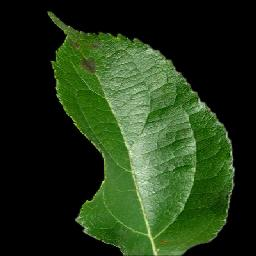

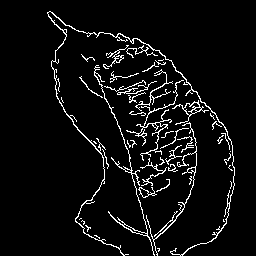

------------End: Edge detection---------------
------------Start: SVM---------------


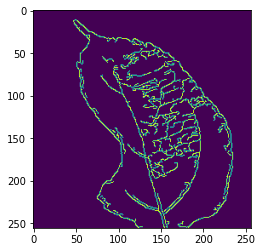

Apple = 97.42584944448333%
Corn = 0.2077405551533819%
Grapes = 0.1277546225046253%
Tomato = 2.2386553778586658%
The predicted image is : Apple
------------End: SVM---------------
------------Start: CNN - Apple---------------
This image most likely belongs to Apple scab with a 57.59 percent confidence.
('Apple scab', 57.59081840515137)
------------End: CNN - Apple---------------


In [41]:
predict_disease('/content/Plants_T_GHL/Test/Apple/Apple scab/381__Apple__Apple scab.JPG')

Given path:  /content/Plants_T_GHL/Test/Apple/Healthy/381__Apple__Healthy.JPG
------------Start: Edge detection---------------


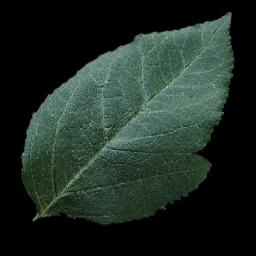

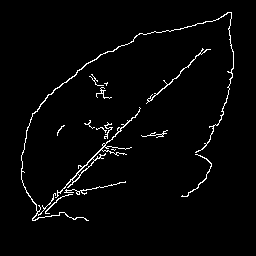

------------End: Edge detection---------------
------------Start: SVM---------------


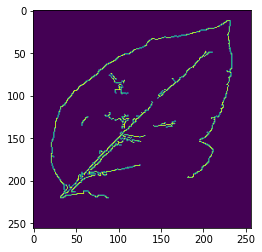

Apple = 99.19438576651484%
Corn = 0.013980055736202484%
Grapes = 0.033137479374911925%
Tomato = 0.7584966983740268%
The predicted image is : Apple
------------End: SVM---------------
------------Start: CNN - Apple---------------
This image most likely belongs to Healthy with a 57.61 percent confidence.
('Healthy', 57.6116681098938)
------------End: CNN - Apple---------------


In [42]:
predict_disease('/content/Plants_T_GHL/Test/Apple/Healthy/381__Apple__Healthy.JPG')

Given path:  /content/Plants_T_GHL/Test/Corn/Common rust/381__Corn__Common rust.JPG
------------Start: Edge detection---------------


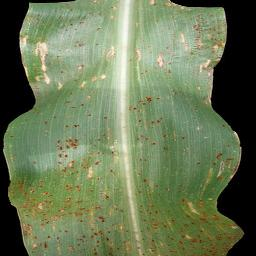

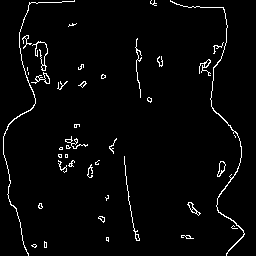

------------End: Edge detection---------------
------------Start: SVM---------------


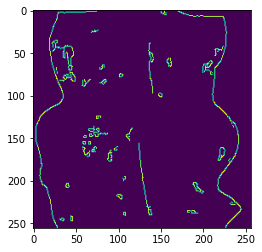

Apple = 3.129247487255169e-05%
Corn = 99.99976721132909%
Grapes = 7.119294100221618e-05%
Tomato = 0.0001303032550613419%
The predicted image is : Corn
------------End: SVM---------------
------------Start: CNN - Corn---------------
This image most likely belongs to Common rust with a 57.61 percent confidence.
('Common rust', 57.61028528213501)
------------End: CNN - Corn---------------


In [43]:
predict_disease('/content/Plants_T_GHL/Test/Corn/Common rust/381__Corn__Common rust.JPG')

Given path:  /content/Plants_T_GHL/Test/Corn/Gray leaf spot/381__Corn__Gray leaf spot.JPG
------------Start: Edge detection---------------


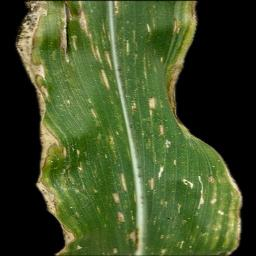

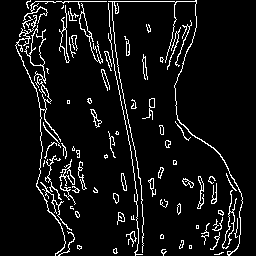

------------End: Edge detection---------------
------------Start: SVM---------------


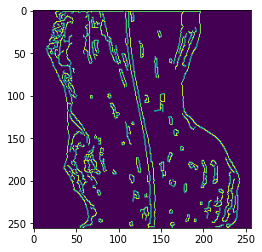

Apple = 0.33934647676140056%
Corn = 99.46130544932242%
Grapes = 0.06929219504120471%
Tomato = 0.13005587887495595%
The predicted image is : Corn
------------End: SVM---------------
------------Start: CNN - Corn---------------
This image most likely belongs to Gray leaf spot with a 57.61 percent confidence.
('Gray leaf spot', 57.61083960533142)
------------End: CNN - Corn---------------


In [44]:
predict_disease('/content/Plants_T_GHL/Test/Corn/Gray leaf spot/381__Corn__Gray leaf spot.JPG')

Given path:  /content/Plants_T_GHL/Test/Corn/Healthy/381__Corn__Healthy.JPG
------------Start: Edge detection---------------


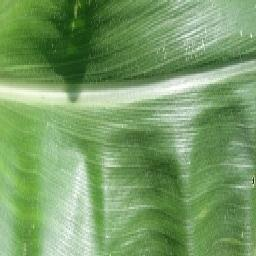

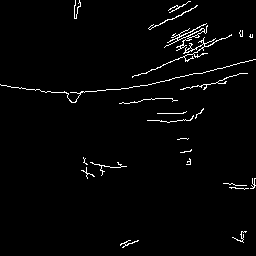

------------End: Edge detection---------------
------------Start: SVM---------------


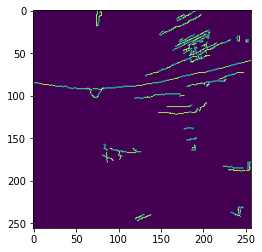

Apple = 0.5289155459162402%
Corn = 99.25341845913462%
Grapes = 0.02925612186151027%
Tomato = 0.18840987308761994%
The predicted image is : Corn
------------End: SVM---------------
------------Start: CNN - Corn---------------
This image most likely belongs to Healthy with a 57.61 percent confidence.
('Healthy', 57.61168599128723)
------------End: CNN - Corn---------------


In [45]:
predict_disease('/content/Plants_T_GHL/Test/Corn/Healthy/381__Corn__Healthy.JPG')

Given path:  /content/Plants_T_GHL/Test/Tomato/Early blight/381__Tomato__Early blight.JPG
------------Start: Edge detection---------------


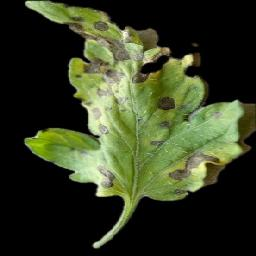

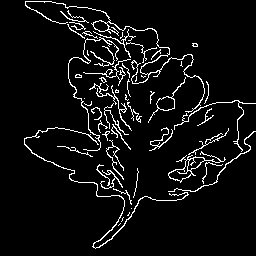

------------End: Edge detection---------------
------------Start: SVM---------------


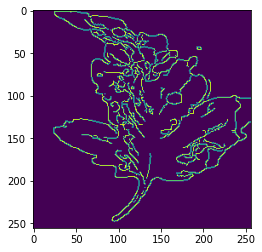

Apple = 2.4456136011990726%
Corn = 0.4724479272218187%
Grapes = 0.37165202226048805%
Tomato = 96.71028644931859%
The predicted image is : Tomato
------------End: SVM---------------
------------Start: CNN - Tomato---------------
This image most likely belongs to Early blight with a 47.54 percent confidence.
('Early blight', 47.53654599189758)
------------End: CNN - Tomato---------------


In [46]:
predict_disease('/content/Plants_T_GHL/Test/Tomato/Early blight/381__Tomato__Early blight.JPG')

Given path:  /content/Plants_T_GHL/Test/Tomato/Healthy/381__Tomato__Healthy.JPG
------------Start: Edge detection---------------


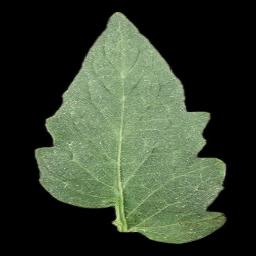

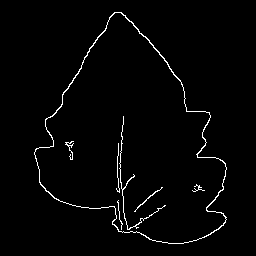

------------End: Edge detection---------------
------------Start: SVM---------------


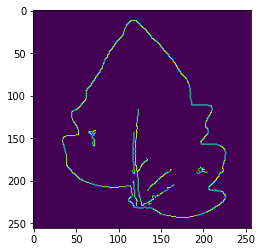

Apple = 0.3552885014678458%
Corn = 0.009505339656883525%
Grapes = 0.07260490717695686%
Tomato = 99.5626012516983%
The predicted image is : Tomato
------------End: SVM---------------
------------Start: CNN - Tomato---------------
This image most likely belongs to Healthy with a 47.54 percent confidence.
('Healthy', 47.536686062812805)
------------End: CNN - Tomato---------------


In [47]:
predict_disease('/content/Plants_T_GHL/Test/Tomato/Healthy/381__Tomato__Healthy.JPG')

Given path:  /content/Plants_T_GHL/Test/Tomato/Leaf mold/381__Tomato__Leaf mold.JPG
------------Start: Edge detection---------------


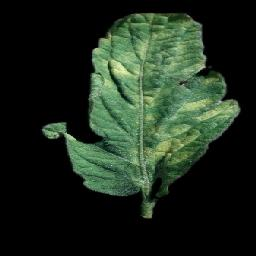

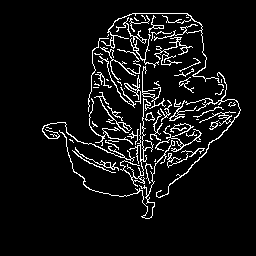

------------End: Edge detection---------------
------------Start: SVM---------------


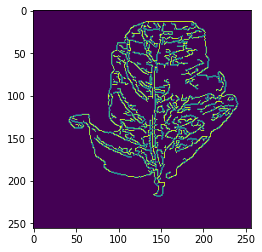

Apple = 2.312699863786321%
Corn = 0.6110443747262104%
Grapes = 0.34098720989113407%
Tomato = 96.73526855159635%
The predicted image is : Tomato
------------End: SVM---------------
------------Start: CNN - Tomato---------------
This image most likely belongs to Leaf mold with a 47.54 percent confidence.
('Leaf mold', 47.536686062812805)
------------End: CNN - Tomato---------------


In [48]:
predict_disease('/content/Plants_T_GHL/Test/Tomato/Leaf mold/381__Tomato__Leaf mold.JPG')

Given path:  /content/Plants_T_GHL/Test/Tomato/Septoria leaf spot/381__Tomato__Septoria leaf spot.JPG
------------Start: Edge detection---------------


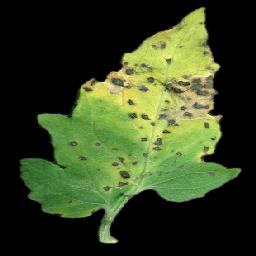

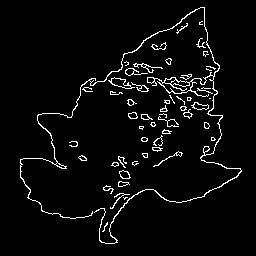

------------End: Edge detection---------------
------------Start: SVM---------------


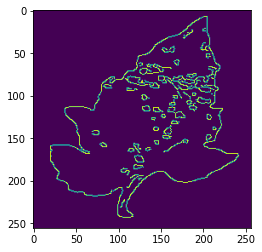

Apple = 2.7467326306315645%
Corn = 0.21476253220630348%
Grapes = 0.176894439316446%
Tomato = 96.86161039784568%
The predicted image is : Tomato
------------End: SVM---------------
------------Start: CNN - Tomato---------------
This image most likely belongs to Septoria leaf spot with a 47.54 percent confidence.
('Septoria leaf spot', 47.536686062812805)
------------End: CNN - Tomato---------------


In [49]:
predict_disease('/content/Plants_T_GHL/Test/Tomato/Septoria leaf spot/381__Tomato__Septoria leaf spot.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Black rot/High/191__Segmented__Black rot__High.JPG
------------Start: Edge detection---------------


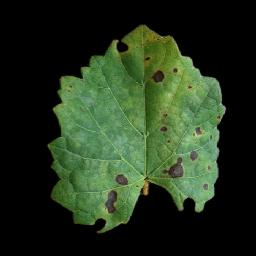

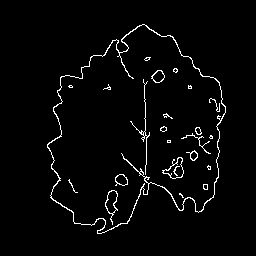

------------End: Edge detection---------------
------------Start: SVM---------------


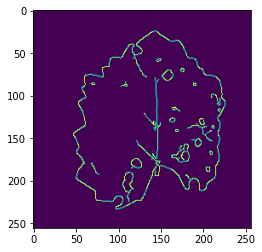

Apple = 24.030504409278123%
Corn = 3.451402406781559%
Grapes = 23.018261211621333%
Tomato = 49.499831972318965%
The predicted image is : Apple
------------End: SVM---------------
------------Start: CNN - Apple---------------
This image most likely belongs to Apple scab with a 57.61 percent confidence.
('Apple scab', 57.611626386642456)
------------End: CNN - Apple---------------


In [50]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Black rot/High/191__Segmented__Black rot__High.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Black rot/Low/191__Segmented__Black rot__Low.JPG
------------Start: Edge detection---------------


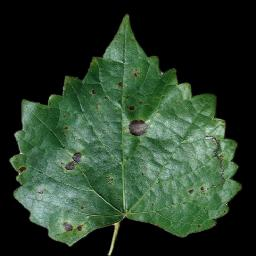

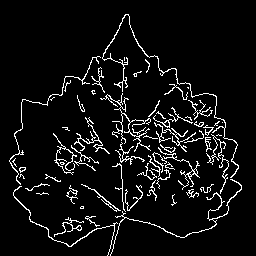

------------End: Edge detection---------------
------------Start: SVM---------------


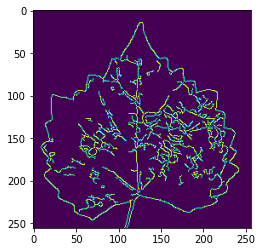

Apple = 0.8578333006871812%
Corn = 0.08787678264137606%
Grapes = 88.28430588715646%
Tomato = 10.769984029514976%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Black rot with a 39.01 percent confidence.
('Black rot', 39.013513922691345)
------------Start: CNN - Grapes - blackrot---------------
This image most likely belongs to Low with a 67.31 percent confidence.
('Low', 67.30772852897644)
------------End: CNN - Grapes - blackrot---------------
------------End: CNN - Grapes---------------


In [51]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Black rot/Low/191__Segmented__Black rot__Low.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Black rot/High/194__Segmented__Black rot__High.JPG
------------Start: Edge detection---------------


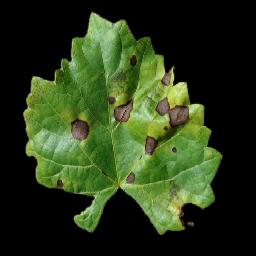

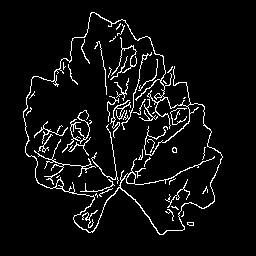

------------End: Edge detection---------------
------------Start: SVM---------------


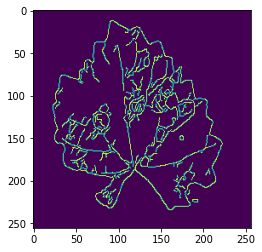

Apple = 0.21737434021729313%
Corn = 0.009359901324231316%
Grapes = 99.50733940734894%
Tomato = 0.26592635110954%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Black rot with a 47.52 percent confidence.
('Black rot', 47.51591980457306)
------------Start: CNN - Grapes - blackrot---------------
This image most likely belongs to High with a 72.64 percent confidence.
('High', 72.63513803482056)
------------End: CNN - Grapes - blackrot---------------
------------End: CNN - Grapes---------------


In [52]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Black rot/High/194__Segmented__Black rot__High.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Esca/High/191__Segmented__Esca__High.JPG
------------Start: Edge detection---------------


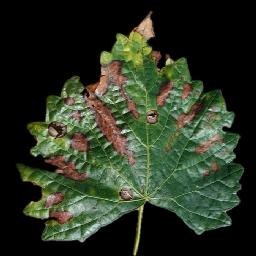

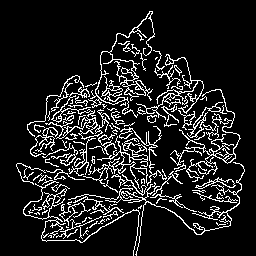

------------End: Edge detection---------------
------------Start: SVM---------------


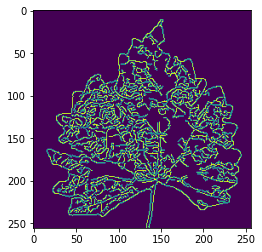

Apple = 0.9524744868985474%
Corn = 1.0152088884629913%
Grapes = 95.02498807186251%
Tomato = 3.0073285527759244%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Esca with a 47.54 percent confidence.
('Esca', 47.536686062812805)
------------Start: CNN - Grapes - Esca---------------
This image most likely belongs to High with a 73.11 percent confidence.
('High', 73.10585379600525)
------------End: CNN - Grapes - Esca---------------
------------End: CNN - Grapes---------------


In [53]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Esca/High/191__Segmented__Esca__High.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Esca/Low/191__Segmented__Esca__Low.JPG
------------Start: Edge detection---------------


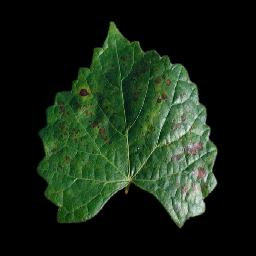

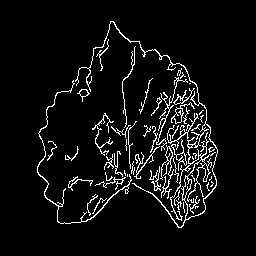

------------End: Edge detection---------------
------------Start: SVM---------------


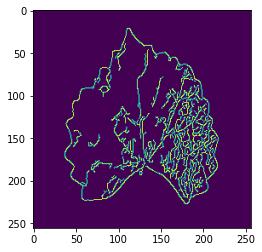

Apple = 4.492890171129095%
Corn = 1.7128706098321043%
Grapes = 57.47453814626235%
Tomato = 36.31970107277646%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Esca with a 47.54 percent confidence.
('Esca', 47.536686062812805)
------------Start: CNN - Grapes - Esca---------------
This image most likely belongs to Low with a 73.11 percent confidence.
('Low', 73.10585379600525)
------------End: CNN - Grapes - Esca---------------
------------End: CNN - Grapes---------------


In [54]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Esca/Low/191__Segmented__Esca__Low.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Healthy/No label/381__Segmented__Healthy.JPG
------------Start: Edge detection---------------


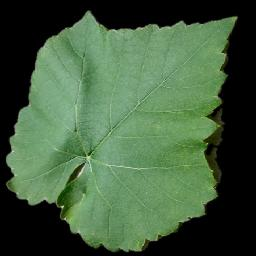

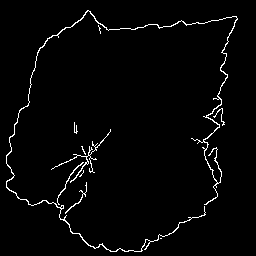

------------End: Edge detection---------------
------------Start: SVM---------------


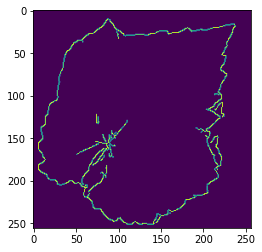

Apple = 26.285200733760533%
Corn = 61.22577392026899%
Grapes = 9.969767518762652%
Tomato = 2.5192578272078365%
The predicted image is : Corn
------------End: SVM---------------
------------Start: CNN - Corn---------------
This image most likely belongs to Common rust with a 57.61 percent confidence.
('Common rust', 57.611674070358276)
------------End: CNN - Corn---------------


In [55]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Healthy/No label/381__Segmented__Healthy.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Healthy/No label/383__Segmented__Healthy.JPG
------------Start: Edge detection---------------


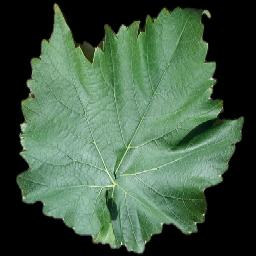

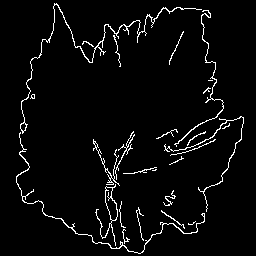

------------End: Edge detection---------------
------------Start: SVM---------------


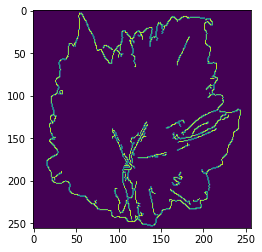

Apple = 0.3782246432444379%
Corn = 0.0726087473584996%
Grapes = 99.46810162470895%
Tomato = 0.0810649846881135%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Healthy with a 47.53 percent confidence.
('Healthy', 47.533148527145386)
------------End: CNN - Grapes---------------


In [56]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Healthy/No label/383__Segmented__Healthy.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Isariopsis/High/191__Segmented__Isariopsis__High.JPG
------------Start: Edge detection---------------


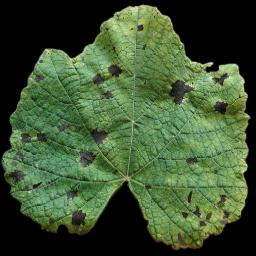

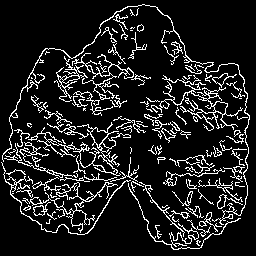

------------End: Edge detection---------------
------------Start: SVM---------------


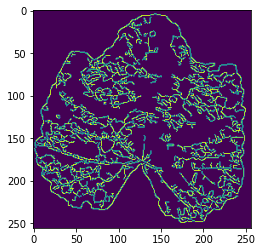

Apple = 0.6254079766255392%
Corn = 0.7258248343863014%
Grapes = 97.03961002947159%
Tomato = 1.609157159516566%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Isariopsis with a 47.54 percent confidence.
('Isariopsis', 47.53667116165161)
------------Start: CNN - Grapes - Isariopsis---------------
This image most likely belongs to High with a 73.11 percent confidence.
('High', 73.10585379600525)
------------End: CNN - Grapes - Isariopsis---------------
------------End: CNN - Grapes---------------


In [57]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Isariopsis/High/191__Segmented__Isariopsis__High.JPG')

Given path:  /content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/191__Segmented__Isariopsis__Low.JPG
------------Start: Edge detection---------------


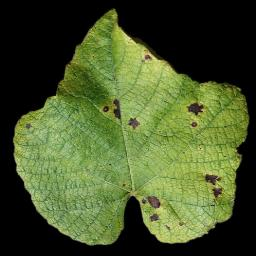

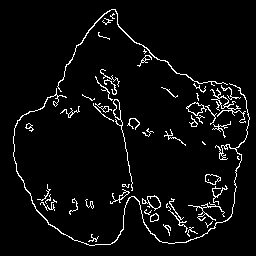

------------End: Edge detection---------------
------------Start: SVM---------------


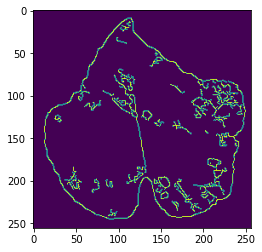

Apple = 19.140025460243834%
Corn = 2.1077881273112538%
Grapes = 76.26100689704685%
Tomato = 2.491179515398035%
The predicted image is : Grapes
------------End: SVM---------------
------------Start: CNN - Grapes---------------
This image most likely belongs to Isariopsis with a 47.54 percent confidence.
('Isariopsis', 47.53668010234833)
------------Start: CNN - Grapes - Isariopsis---------------
This image most likely belongs to Low with a 73.11 percent confidence.
('Low', 73.10585379600525)
------------End: CNN - Grapes - Isariopsis---------------
------------End: CNN - Grapes---------------


In [58]:
predict_disease('/content/Plants_T_GHL/Test/Grapes/Isariopsis/Low/191__Segmented__Isariopsis__Low.JPG')